In [1]:
pwd

'/data2/mito_lineage/src/vireo'

In [2]:
# INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse"
# OUTDIR= "data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3"
# N_DONORS=4 
# #INDIR=""
# sample_names="" #"Control,Flt3l,Input"
curr_dir="/data2/mito_lineage"
INDIR="data/processed/mttrace/CHIP_april08_2021/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex"
OUTDIR="data/processed/mttrace/CHIP_april08_2021/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/dendrograms"
#OUTDIR= "data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.01/numC100000_ispropFalse/variants"
N_DONORS=5 
sample_names="Control,Flt3l,Input"

In [3]:
import os
from src.utils.data_io import setup_outdir
os.chdir(curr_dir)
setup_outdir(OUTDIR, dirs=('figures',))

In [4]:
sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}

In [5]:
import mplh.cluster_help as ch
from os.path import join, exists, dirname
import matplotlib.pyplot as plt
import vireoSNP
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import mmread

In [6]:
def filt_high(df, thresh):
    return df.loc[(df.mean(axis=1)<thresh)].index.values


# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

## Load cluster results and test for enrichment

In [7]:
import seaborn as sns
from mplh import cluster_help as ch

data/processed/mttrace/CHIP_april08_2021/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor0.AD.mtx
data/processed/mttrace/CHIP_april08_2021/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor0.DP.mtx
clustering
cmap None
clustering
cmap None
clustering
cmap None
data/processed/mttrace/CHIP_april08_2021/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor1.AD.mtx
data/processed/mttrace/CHIP_april08_2021/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor1.DP.mtx
clustering
cmap None
clustering
cmap None
clustering
cmap None
data/processed/mttrace/CHIP_april08_2021/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_to

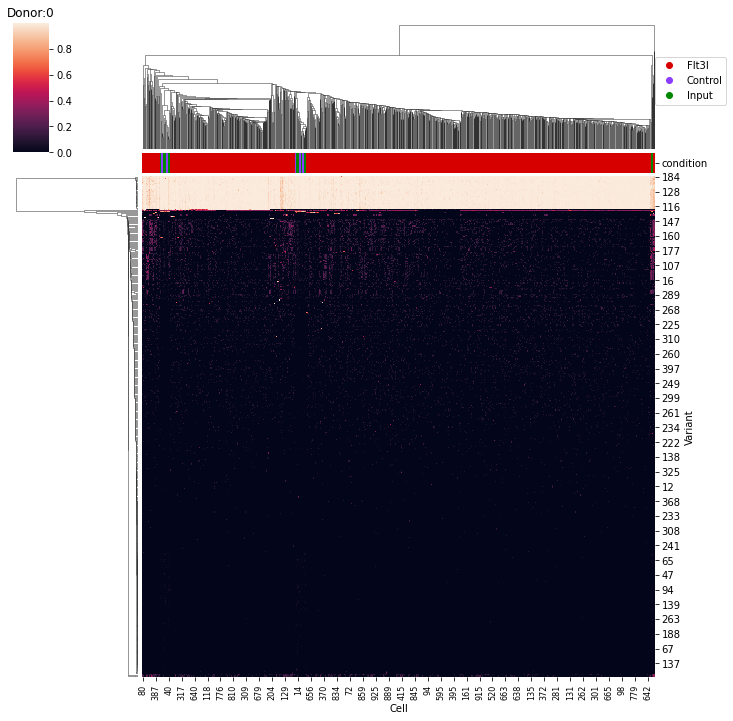

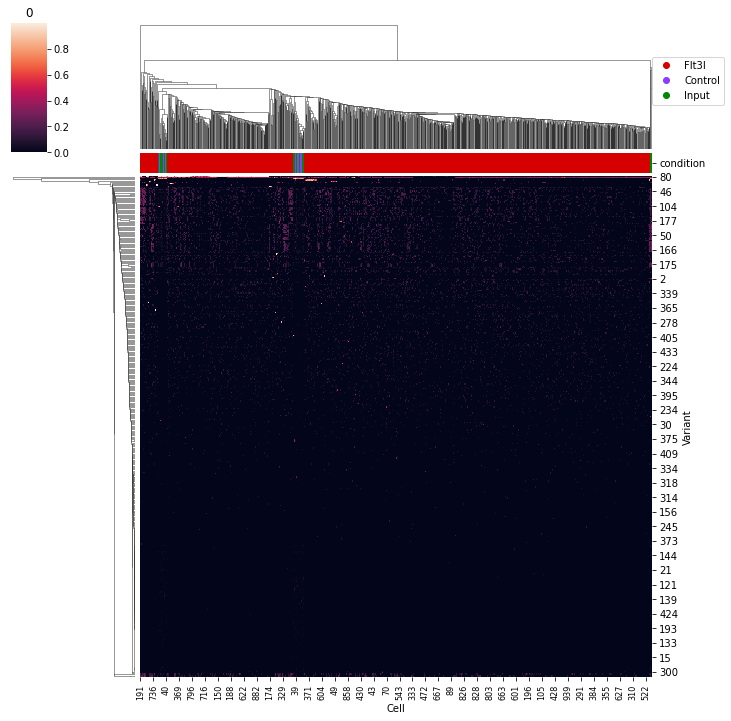

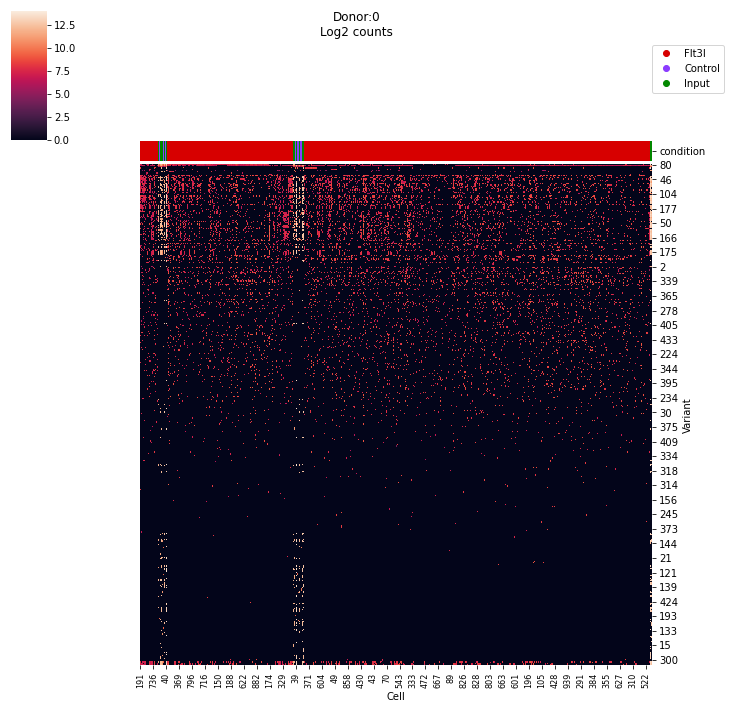

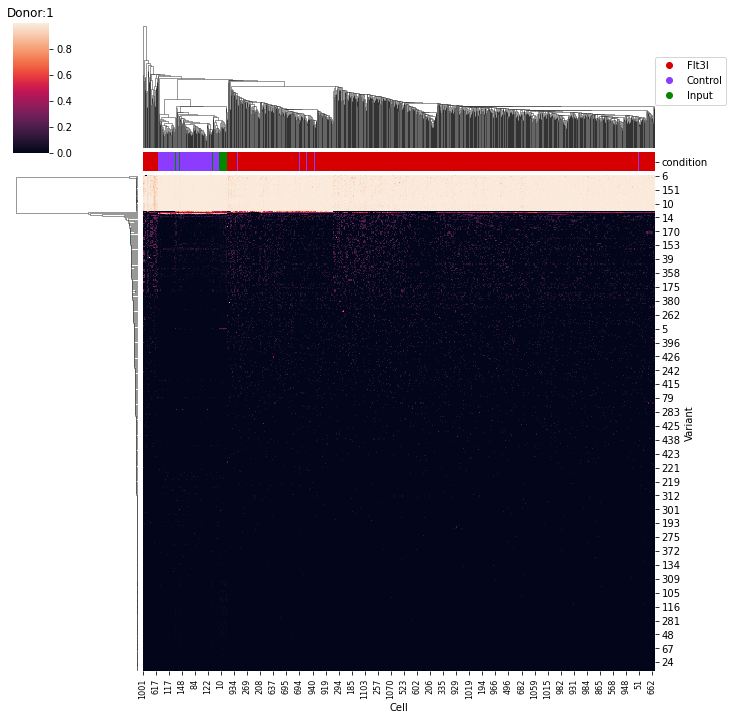

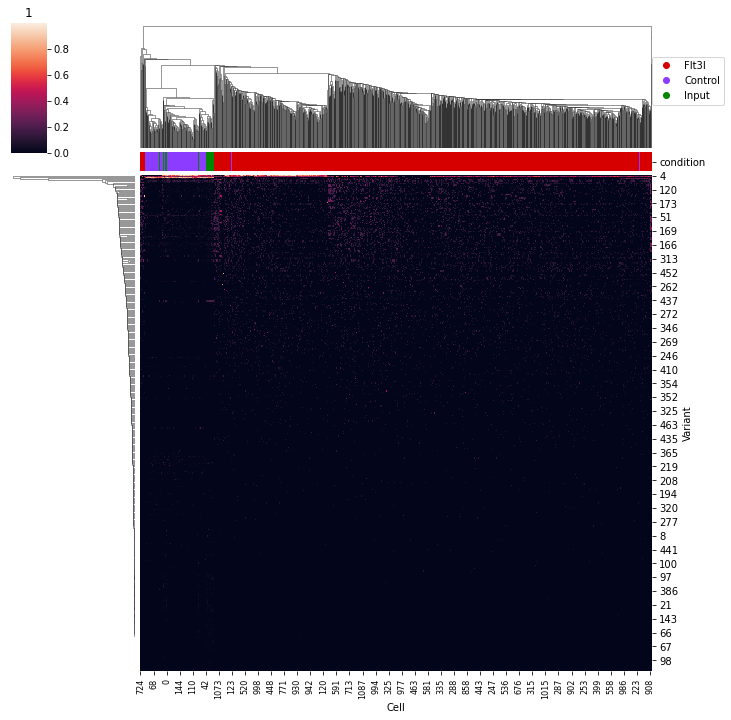

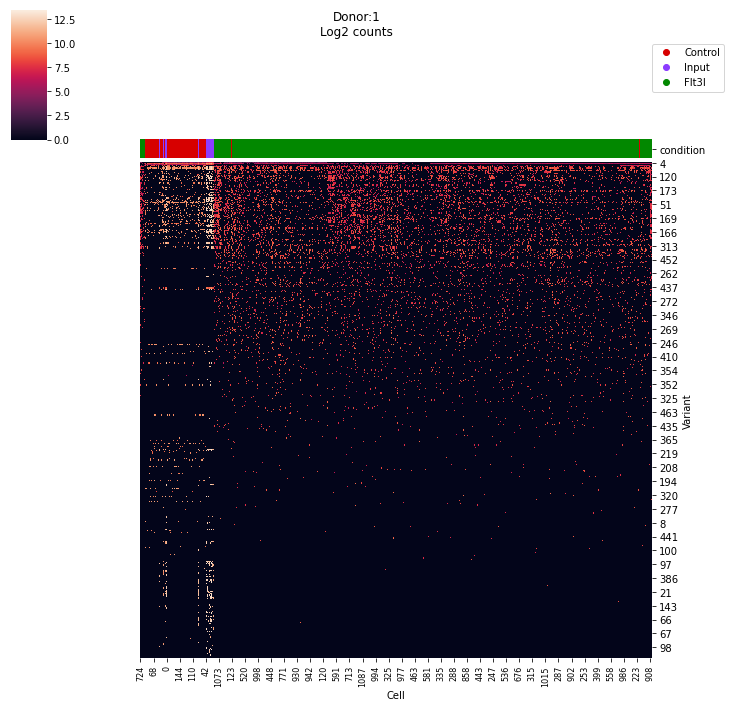

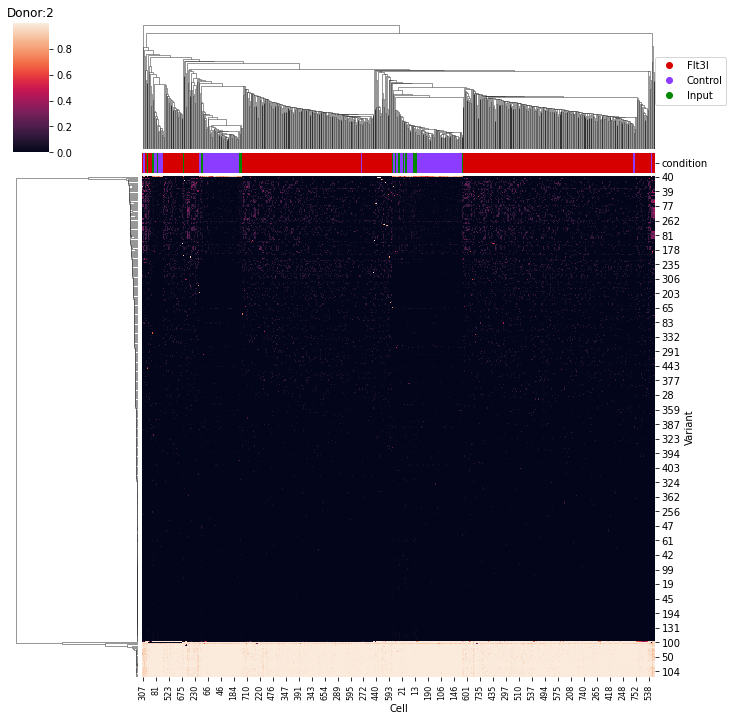

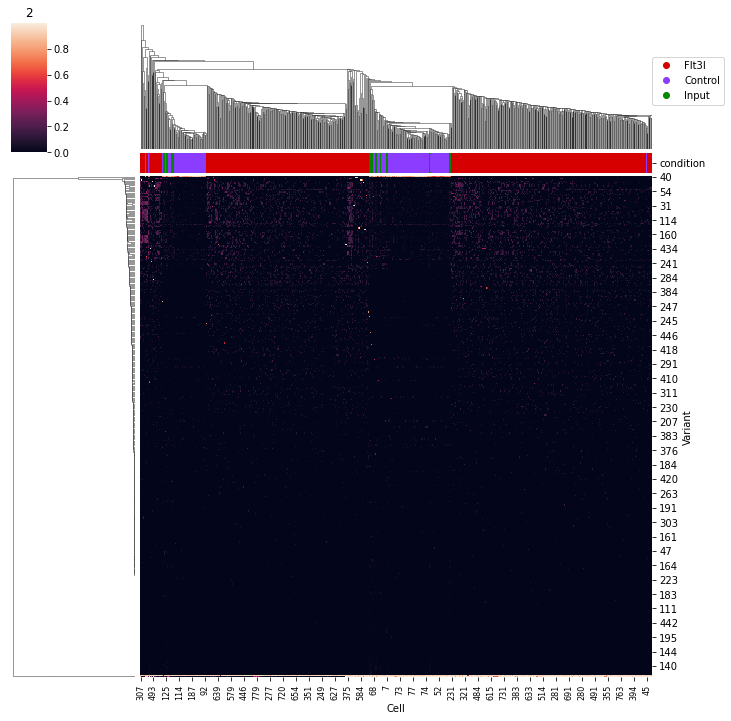

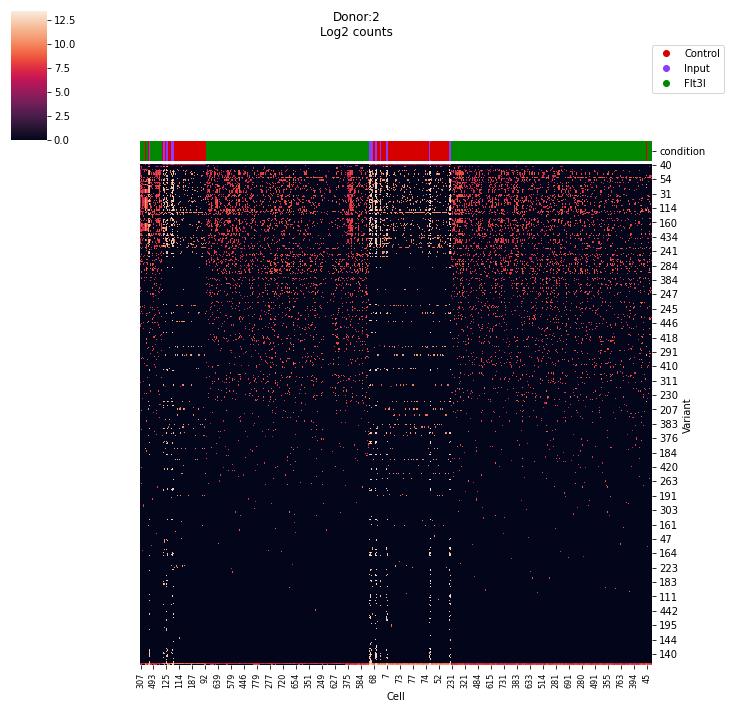

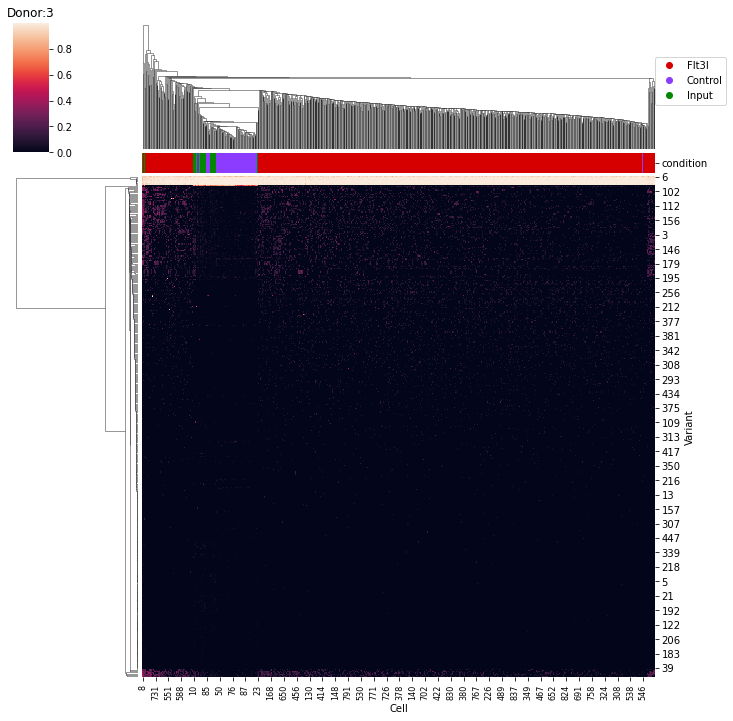

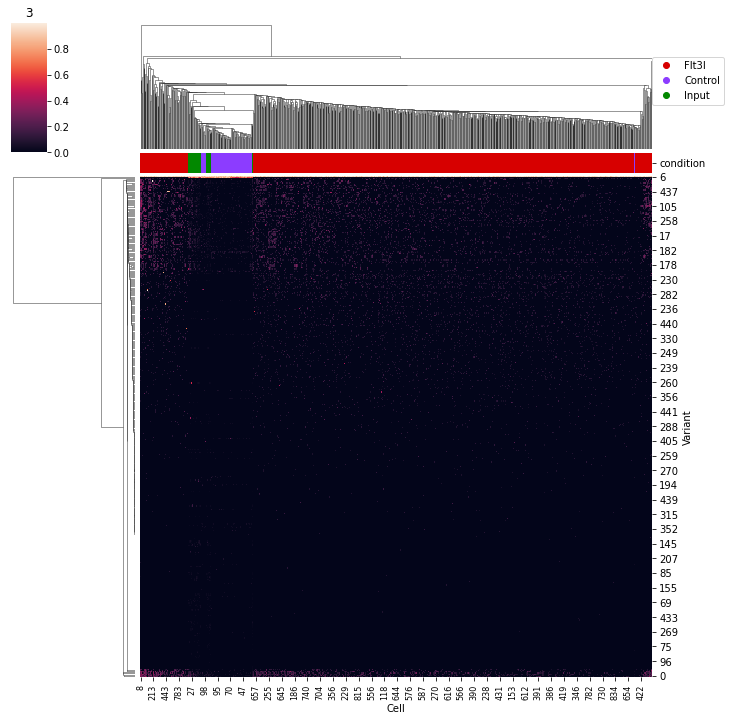

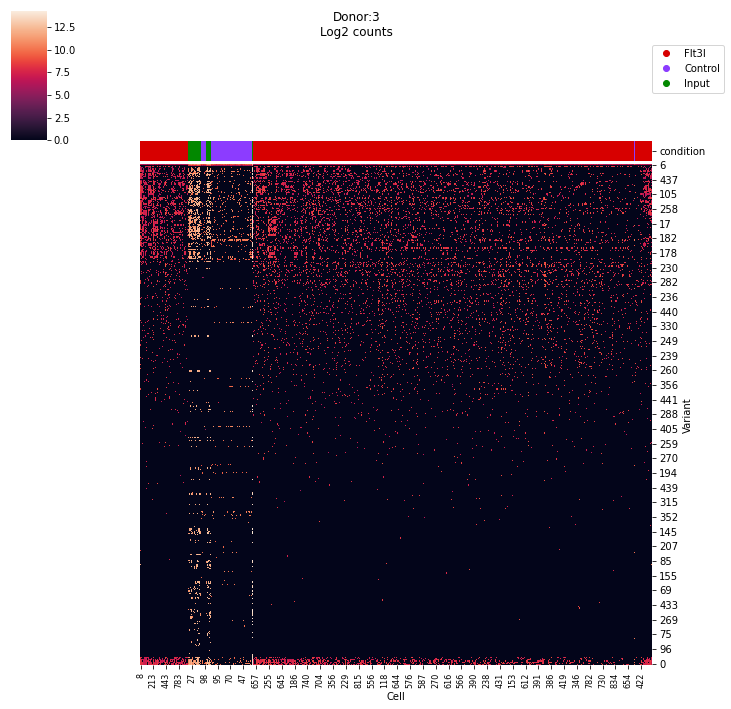

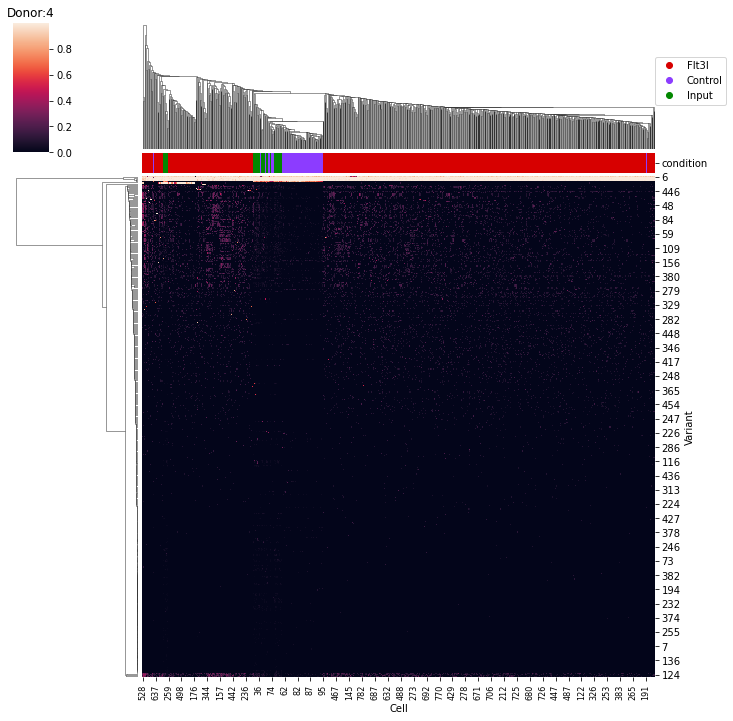

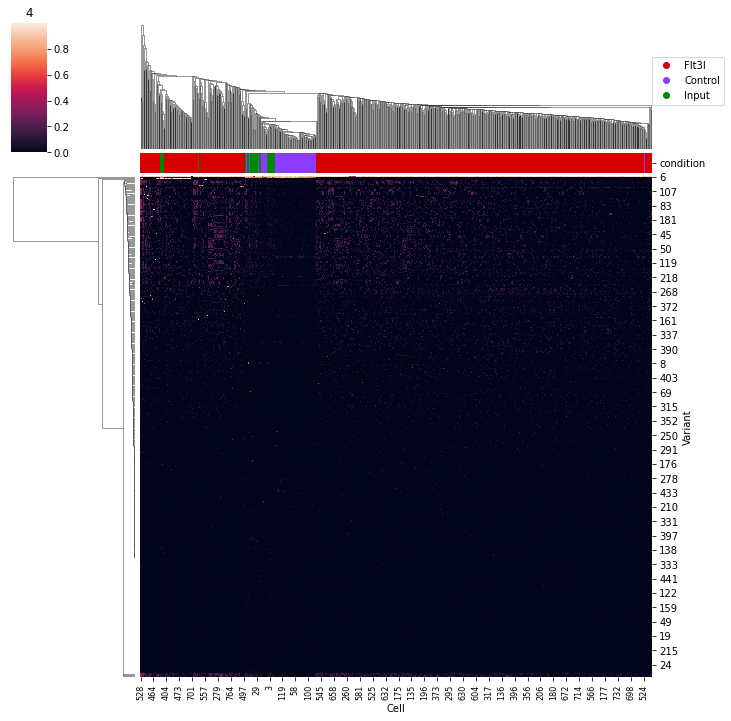

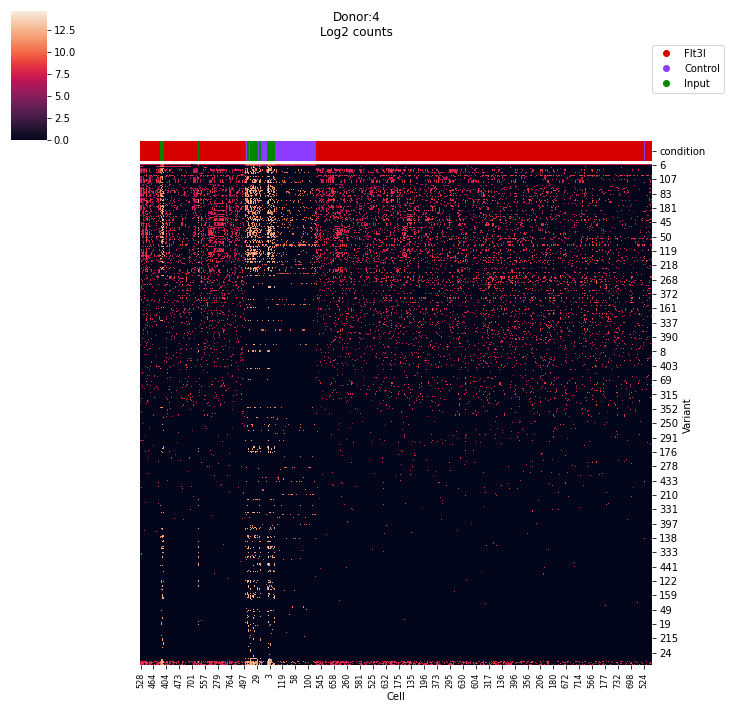

In [8]:
#n_clone_list = [7]#[2,3,4,5,6,7]
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), index_col=0, sep='\t')
cells_meta = cells_meta.astype({"donor":"Int64", 'donor_index': 'Int64'})

for n in range(N_DONORS):
    out_f = join(OUTDIR,'figures', f"donor{n}_dendrogram.png")
    curr_ad_f = join(INDIR, f"donor{n}.AD.mtx")
    curr_dp_f = join(INDIR, f"donor{n}.DP.mtx")
    print(curr_ad_f)
    print(curr_dp_f)
    curr_ad = mmread(curr_ad_f).tocsc()
    curr_dp = mmread(curr_dp_f).tocsc()
    AD_df = pd.DataFrame(curr_ad.todense())
    DP_df = pd.DataFrame(curr_dp.todense())
    DP_df.index.name = "Variant"
    DP_df.columns.name = "Cell"
    AD_df.index.name = "Variant"
    AD_df.columns.name = "Cell"
    AF_df = AD_df/(DP_df+0.001)
    #AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    curr_labels = cells_meta.loc[cells_meta['donor']==n].sort_values("donor_index").reset_index()
    
    #curr_labels = pd.read_csv(join(INDIR, f"donor{n}.labels.txt"), index_col=0)
    
    
    #cols=np.random.choice(AF_df.columns,size=500, replace=False)
#     cols = AF_df.columns
    
#     #f, ax = plt.subplots(nrows=2, ncols=1)
#     raw_af = AF_df.copy()
#     AF_df = AF_df.loc[:,cols]
#     DP_df = DP_df.loc[:,cols]
#     curr_labels = curr_labels.loc[cols]
    
    #colors={val[0]:val[1] for val in zip(sample_names, sns.color_palette('Set2', len(sample_names)))}
    #curr_labels["Color"] = curr_labels["sample ID"].map(colors)
    
    g = ch.plot_cluster(np.sqrt(AF_df), col_meta=curr_labels[["condition"]], to_row_clust=True, to_col_clust=True, use_white=False )
    #g = sns.clustermap(np.sqrt(AF_df), col_colors=curr_labels[["Color"]], to_row_clust=True, to_col_clust=True, metric='jaccard')
    plt.suptitle(f"Donor:{n}")
    plt.savefig(out_f+".withHigh.png")
    
    cols2 = filt_high(AF_df, thresh=0.9)
    AF_df = AF_df.loc[cols2]
    DP_df = DP_df.loc[cols2]
    #curr_labels = curr_labels.iloc[cols2]
    
    g = ch.plot_cluster(np.sqrt(AF_df), col_meta=curr_labels[["condition"]], to_row_clust=True, to_col_clust=True, use_white=False )
    #g = sns.clustermap(np.sqrt(AF_df), col_colors=curr_labels[["Color"]], to_row_clust=True, to_col_clust=True)
    plt.suptitle(f"{n}")
    plt.savefig(out_f)
    
    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]

    ch.plot_cluster(np.log2(DP_df.iloc[inds, cols]+1), to_row_clust=False, to_col_clust=False, 
                            col_meta=curr_labels.iloc[cols][["condition"]], use_white=False )

    plt.suptitle(f"Donor:{n}\nLog2 counts")
    plt.savefig(out_f+".depth.png")

In [9]:
curr_labels.iloc[cols2][["condition"]]

,condition
0,Input
1,Input
2,Input
3,Input
4,Input
...,...
453,Flt3l
454,Flt3l
455,Flt3l
456,Flt3l


clustering
cmap None


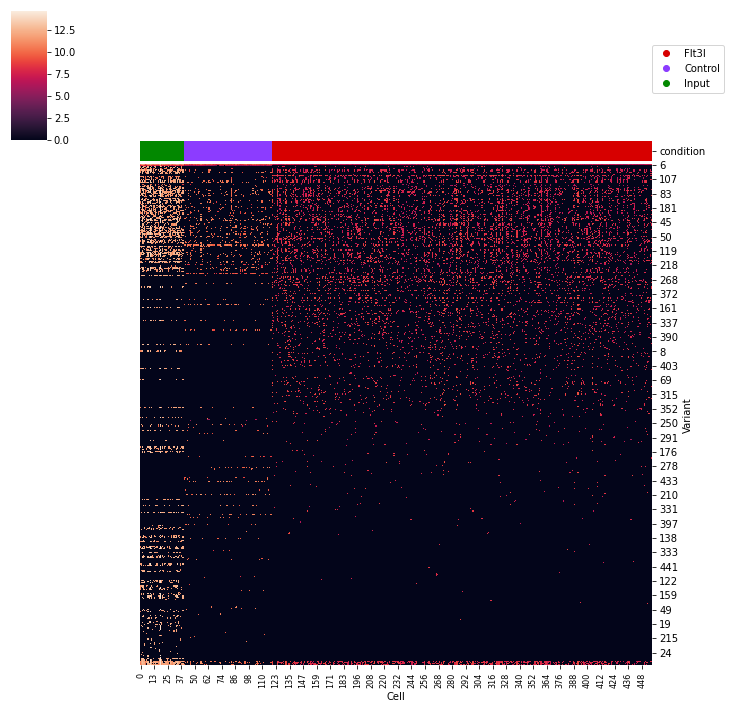

In [10]:
import mplh.cluster_help as ch

ch.plot_cluster(np.log2(DP_df.iloc[inds, cols2]+1), to_row_clust=False, to_col_clust=False, 
                        col_meta=curr_labels.iloc[cols2][["condition"]], use_white=False )


In [11]:
np.unique(curr_labels.iloc[cols2]["condition"])

array(['Control', 'Flt3l', 'Input'], dtype=object)

In [12]:
curr_labels

,new index,ID,raw ID,condition,donor,donor_index
0,2,AAAGGATAGTCGTGAG-1_Input,AAAGGATAGTCGTGAG-1,Input,4,1
1,15,ACAGAAATCTGGCACG-1_Input,ACAGAAATCTGGCACG-1,Input,4,2
2,23,ACCCAAAAGGAAGGTA-1_Input,ACCCAAAAGGAAGGTA-1,Input,4,3
3,25,ACCTGCTCACGCGTTG-1_Input,ACCTGCTCACGCGTTG-1,Input,4,4
4,30,AGCCGCAGTCCGTGCA-1_Input,AGCCGCAGTCCGTGCA-1,Input,4,5
...,...,...,...,...,...,...
789,4764,TTTGAGGGTAAGGTCG-1_Flt3l,TTTGAGGGTAAGGTCG-1,Flt3l,4,790
790,4766,TTTGAGGGTTAGGCTT-1_Flt3l,TTTGAGGGTTAGGCTT-1,Flt3l,4,791
791,4781,TTTGGCCAGTTCTCCC-1_Flt3l,TTTGGCCAGTTCTCCC-1,Flt3l,4,792
792,4783,TTTGGCCGTGACCAGA-1_Flt3l,TTTGGCCGTGACCAGA-1,Flt3l,4,793
